<a href="https://colab.research.google.com/github/agodavarthy/fraudpolicing/blob/main/Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [20]:
!export PYDEVD_DISABLE_FILE_VALIDATION=1

In [22]:
from google.colab import drive

In [21]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [23]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [24]:

# 1. Load and prepare the data
def load_data():

    drive.mount('/content/drive')
    file_path = '/content/drive/MyDrive/IK_ProjectUp/FraudDetection/data/fraud_detection_ds/'
    data_path = file_path+'engineered_dataset_apr13.csv'
    df = pd.read_csv(data_path, index_col=None)
    df = df.drop(['trans_num', 'trans_cnt_cust'], axis=1)

    return df

# Load data
df = load_data()
print(f"Data shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].mean():.2%}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data shape: (1852394, 38)
Fraud rate: 0.52%


In [27]:
print(f"Data shape: {df.shape}")
print(f"Fraud rate: {df[df.is_fraud==1].shape[0]/df[df.is_fraud == 0].shape[0]:.2%}")

Data shape: (1852394, 38)
Fraud rate: 0.52%


In [12]:
df[['cc_num', 'transaction_year', 'transaction_month']].tail(100)

,cc_num,transaction_year,transaction_month
1852294,4992346398065154184,2020,12
1852295,4992346398065154184,2020,12
1852296,4992346398065154184,2020,12
1852297,4992346398065154184,2020,12
1852298,4992346398065154184,2020,12
...,...,...,...
1852389,4992346398065154184,2020,12
1852390,4992346398065154184,2020,12
1852391,4992346398065154184,2020,12
1852392,4992346398065154184,2020,12


In [28]:
# 2. Feature Engineering
# Sort by customer_id and timestamp
df = df.sort_values(['cc_num', 'trans_date_trans_time'])
df = df.drop(['trans_date_trans_time'], axis=1)

In [25]:
df = df[:100000]

In [27]:
df[['cc_num', 'transaction_year', 'transaction_month']].head(100)

,cc_num,transaction_year,transaction_month
0,60416207185,2019,1
1,60416207185,2019,1
2,60416207185,2019,1
3,60416207185,2019,1
4,60416207185,2019,1
...,...,...,...
95,60416207185,2019,2
96,60416207185,2019,2
97,60416207185,2019,2
98,60416207185,2019,2


In [28]:
def impute_scale(X_train, X_test):
  #print("Starting imputer....")
  imputer = SimpleImputer(strategy='mean')
  X_train_imputed = imputer.fit_transform(X_train)
  X_test_imputed = imputer.transform(X_test)
  #print("Done with imputer!")

  print("Starting Standard Scaler....")
  std_scaler = StandardScaler()
  print("Starting Standard Scaler....Init")
  X_train_std_scaled = std_scaler.fit_transform(X_train_imputed)
  print("Standard Scaler Fit train")
  X_test_std_scaled = std_scaler.transform(X_test_imputed)
  print("Done with Standard Scaler!")

  #print("Starting MinMax Scaler....")
  minmax_scaler = MinMaxScaler()
  #print("MinMax Scaler Init()")
  X_train_scaled = minmax_scaler.fit_transform(X_train_std_scaled)
  #print("MinMax Scaler Init()")
  X_test_scaled = minmax_scaler.transform(X_test_std_scaled)
  #print("Done with MinMax Scaler!")
  return X_train_std_scaled, X_test_std_scaled

In [29]:
# Create sequence data for each customer
def create_sequences(data, window_size=10):
    """
    Create sequence data for LSTM model
    Each sequence consists of window_size consecutive transactions for a customer
    """
    X_seq = []
    y_seq = []

    # Group by customer
    cnt = 0
    for customer, group in data.groupby('cc_num'):
        if len(group) < window_size:
            continue
        #print(customer, " customer:", group)
        # Numeric features for sequence
        numeric_features = group.select_dtypes(include=['number'])
        #print(customer, " numeric features = ", numeric_features)
        seq_data = group.values

        # Create sequences
        for i in range(len(group) - window_size):
            X_seq.append(seq_data[i:i+window_size])
            y_seq.append(group['is_fraud'].values[i+window_size])

    return np.array(X_seq), np.array(y_seq)



In [ ]:
df = df.drop(['trans_date_trans_time'], axis=1)

In [38]:
# Create sequences
window_size = 5  # Use 5 previous transactions to predict the next one
X_seq, y_seq = create_sequences(df, window_size)
print(f"Sequence data shape: {X_seq.shape}, Labels shape: {y_seq.shape}")

Sequence data shape: (99720, 5, 37), Labels shape: (99720,)


In [39]:
# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

In [40]:
# 4. Standardize features
# Reshape to 2D for standardization
n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

In [41]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_reshaped)
X_test_imputed = imputer.transform(X_test_reshaped)

In [42]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
# MinMax Standardize
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train_scaled)
#X_test_scaled = scaler.transform(X_test_scaled)

In [43]:


#X_train_scaled, X_test_scaled = impute_scale(X_train_reshaped, X_test_reshaped)


# Reshape back to 3D
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [ ]:
X_train_scaled.shape

(1477919, 5, 37)

In [44]:
# 5. Create PyTorch dataset and dataloader
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [45]:
# Calculate class weights for imbalanced data
n_neg, n_pos = np.bincount(y_train.astype(int))
print("n_neg = ", n_neg)
print("n_pos = ", n_pos)

n_neg =  79370
n_pos =  406


In [46]:



pos_weight = torch.tensor([n_neg/n_pos])
print(f"Positive class weight: {pos_weight.item()}")

# Create datasets and dataloaders
batch_size = 64
train_dataset = FraudDataset(X_train_scaled, y_train)
test_dataset = FraudDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Positive class weight: 195.49261083743843


In [47]:
# 6. Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.dropout_rate = dropout_rate

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x seq_len x input_size

        # First LSTM layer
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)

        # Second LSTM layer
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)

        # Extract the output of the last time step
        lstm2_out = lstm2_out[:, -1, :]

        # Fully connected layers
        fc1_out = self.relu(self.fc1(lstm2_out))
        output = self.fc2(fc1_out)
        #output = self.sigmoid(fc2_out)

        return output

In [48]:

# Initialize model
input_size = X_train_scaled.shape[2]  # Number of features
hidden_size1 = 64
hidden_size2 = 32
output_size = 1  # Binary output

model = LSTMModel(input_size, hidden_size1, hidden_size2, output_size)
model = model.to(device)
print(model)

# 7. Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # Binary Cross Entropy with class weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

LSTMModel(
  (lstm1): LSTM(37, 64, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [49]:
# 8. Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_auc': []
    }

    # For early stopping
    best_val_auc = 0
    patience = 5
    counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze()

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation
        val_loss, val_acc, val_auc = evaluate_model(model, test_loader, criterion)

        # Print stats
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')
        print('-' * 50)

        # Save history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Early stopping
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_lstm_model.pt')
        else:
            counter += 1

        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Load best model
    model.load_state_dict(torch.load('best_lstm_model.pt'))
    return model, history

In [50]:
# 9. Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze()

            # Calculate loss
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save probabilities and labels for AUC calculation
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate statistics
    loss = running_loss / len(data_loader.dataset)
    acc = correct / total

    # Calculate AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return loss, acc, roc_auc



In [51]:
# 10. Train the model
model, history = train_model(model, train_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2: 100%|██████████| 1247/1247 [00:10<00:00, 124.56it/s]


Epoch 1/2
Train Loss: 0.4617, Train Acc: 0.9947
Val Loss: 0.3173, Val Acc: 0.9981, Val AUC: 0.9596
--------------------------------------------------


Epoch 2/2: 100%|██████████| 1247/1247 [00:09<00:00, 126.81it/s]


Epoch 2/2
Train Loss: 0.3290, Train Acc: 0.9985
Val Loss: 0.3011, Val Acc: 0.9987, Val AUC: 0.9674
--------------------------------------------------


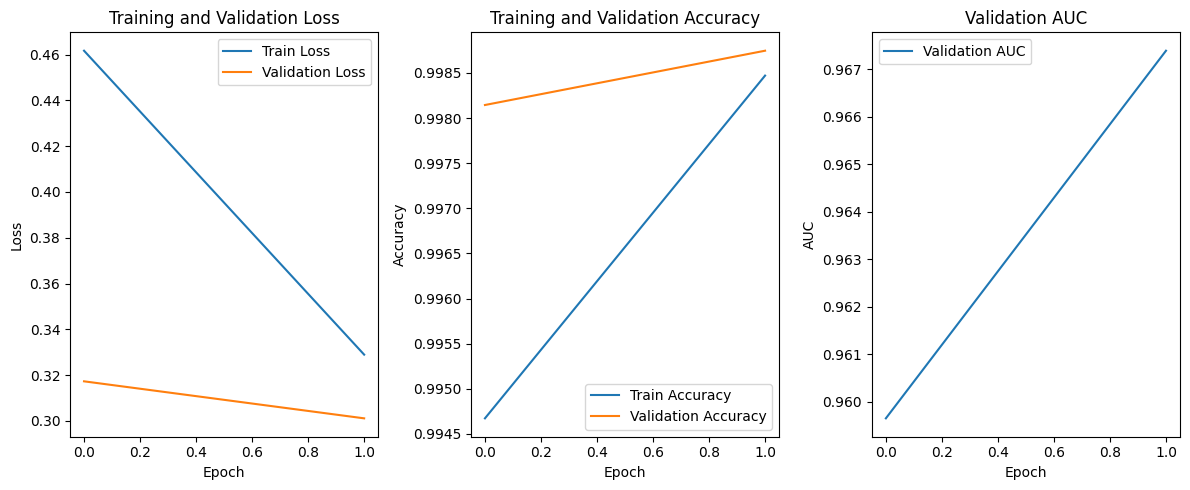

In [52]:
# 11. Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # AUC plot
    plt.subplot(1, 3, 3)
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [53]:
# 12. Final evaluation
test_loss, test_acc, test_auc = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test AUC: {test_auc:.4f}")

Final Test Loss: 0.3011
Final Test Accuracy: 0.9987
Final Test AUC: 0.9674


In [54]:
# 13. Get predictions for the test set
model.eval()
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()

        all_probs.extend(outputs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 14. Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19843
         1.0       0.85      0.92      0.88       101

    accuracy                           1.00     19944
   macro avg       0.92      0.96      0.94     19944
weighted avg       1.00      1.00      1.00     19944


Confusion Matrix:
[[19826    17]
 [    8    93]]


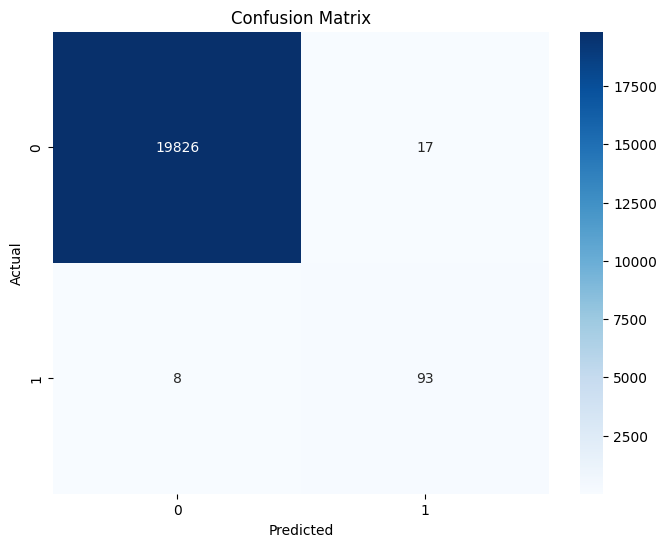

In [55]:
# 15. Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

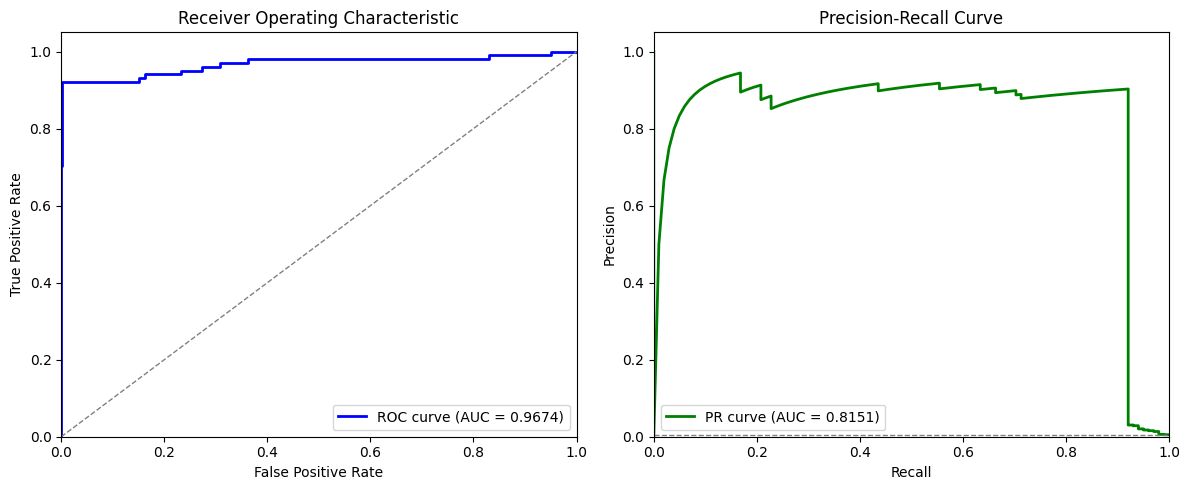

In [56]:
# 16. Plot ROC curve and Precision-Recall curve
def plot_performance_curves(y_true, y_pred_proba):
    plt.figure(figsize=(12, 5))

    # ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Precision-Recall curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.axhline(y=sum(y_true)/len(y_true), color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Plot curves
plot_performance_curves(all_labels, all_probs)

In [57]:
# 17. Function to make predictions on new data
def predict_fraud(model, new_data, scaler):
    """
    Make predictions on new sequence data

    Args:
        model: Trained LSTM model
        new_data: New transaction data as NumPy array with shape (n_samples, window_size, n_features)
        scaler: The fitted StandardScaler

    Returns:
        Fraud probabilities for each sequence
    """
    model.eval()

    # Ensure proper shape
    if len(new_data.shape) == 2:
        new_data = np.expand_dims(new_data, axis=0)

    # Reshape for scaling
    n_samples, n_timesteps, n_features = new_data.shape
    new_data_reshaped = new_data.reshape(-1, n_features)

    # Scale
    new_data_scaled = scaler.transform(new_data_reshaped)

    # Reshape back
    new_data_scaled = new_data_scaled.reshape(new_data.shape)

    # Convert to tensor
    new_data_tensor = torch.FloatTensor(new_data_scaled).to(device)

    # Predict
    with torch.no_grad():
        fraud_probabilities = model(new_data_tensor).squeeze().cpu().numpy()

    return fraud_probabilities

# Example of using the prediction function
# In a real-world scenario, you would have new transaction data
sample_new_data = X_test[:3]  # Just using a few test samples as an example
fraud_probs = predict_fraud(model, sample_new_data, scaler)
print("\nSample Fraud Probabilities:")
for i, prob in enumerate(fraud_probs):
    print(f"Sequence {i+1}: {prob:.4f} ({'Fraud' if prob > 0.5 else 'Normal'})")


Sample Fraud Probabilities:
Sequence 1: -2.3050 (Normal)
Sequence 2: -2.5423 (Normal)
Sequence 3: -2.4324 (Normal)


In [ ]:
# 18. Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'input_size': input_size,
    'hidden_size1': hidden_size1,
    'hidden_size2': hidden_size2,
    'output_size': output_size
}, 'lstm_fraud_detection_model.pt')
print("\nModel saved to 'lstm_fraud_detection_model.pt'")

In [ ]:
# 19. Function to load the model
def load_fraud_detection_model(model_path):
    """
    Load the trained fraud detection model

    Args:
        model_path: Path to the saved model

    Returns:
        Loaded model and scaler
    """
    checkpoint = torch.load(model_path, map_location=device)

    # Create model with the same architecture
    model = LSTMModel(
        checkpoint['input_size'],
        checkpoint['hidden_size1'],
        checkpoint['hidden_size2'],
        checkpoint['output_size']
    )

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Get scaler
    scaler = checkpoint['scaler']

    return model, scaler

# Example of loading the model
# loaded_model, loaded_scaler = load_fraud_detection_model('lstm_fraud_detection_model.pt')

In [ ]:

# 1. Load and prepare the data
# Replace this with your actual data loading code
def load_data():
    """
    Sample function to load fraud data
    In a real scenario, you would load your data from a file or database
    """
    # For this example, we'll create synthetic data
    # Real fraud detection would use transaction data with timestamps

    # Features that might be relevant:
    # - Transaction amount
    # - Time since last transaction
    # - Transaction location (encoded)
    # - Transaction type (encoded)
    # - Device used
    # - etc.

    n_samples = 10000
    n_features = 10

    # Generate features
    X = np.random.randn(n_samples, n_features)

    # Generate target (fraud is typically rare - e.g. 1-2%)
    fraud_rate = 0.02
    y = np.random.choice([0, 1], size=n_samples, p=[1-fraud_rate, fraud_rate])

    # Create a DataFrame to simulate real-world data
    feature_names = [f'feature_{i}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=feature_names)
    df['transaction_amount'] = np.abs(np.random.normal(100, 200, n_samples))
    df['transaction_type'] = np.random.choice(['online', 'in_store', 'mobile'], n_samples)
    df['customer_id'] = np.random.randint(1, 1000, n_samples)
    df['timestamp'] = pd.date_range(start='2023-01-01', periods=n_samples, freq='5min')
    df['is_fraud'] = y

    return df

# Load data
df = load_data()
print(f"Data shape: {df.shape}")
print(f"Fraud rate: {df['is_fraud'].mean():.2%}")



In [ ]:
# 2. Feature Engineering
# Sort by customer_id and timestamp
df = df.sort_values(['customer_id', 'timestamp'])

# Create sequence data for each customer
def create_sequences(data, window_size=10):
    """
    Create sequence data for LSTM model
    Each sequence consists of window_size consecutive transactions for a customer
    """
    X_seq = []
    y_seq = []

    # Group by customer
    for customer, group in data.groupby('customer_id'):
        if len(group) < window_size:
            continue

        # Numeric features for sequence
        numeric_features = ['transaction_amount'] + [f'feature_{i}' for i in range(10)]
        seq_data = group[numeric_features].values

        # Create sequences
        for i in range(len(group) - window_size):
            X_seq.append(seq_data[i:i+window_size])
            y_seq.append(group['is_fraud'].values[i+window_size])

    return np.array(X_seq), np.array(y_seq)

# Create sequences
window_size = 5  # Use 5 previous transactions to predict the next one
X_seq, y_seq = create_sequences(df, window_size)
print(f"Sequence data shape: {X_seq.shape}, Labels shape: {y_seq.shape}")

In [ ]:
# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# 4. Standardize features
# Reshape to 2D for standardization
n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to 3D
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)


In [ ]:
# 5. Build the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )

    return model

# Create model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model = create_lstm_model(input_shape)
model.summary()

In [ ]:
# 6. Train the model
# Due to class imbalance, we use class weights
# Calculate class weights
n_neg, n_pos = np.bincount(y_train.astype(int))
class_weight = {0: 1.0, 1: n_neg/n_pos}
print(f"Class weights: {class_weight}")

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=5, mode='max', restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stopping]
)

In [ ]:
# 7. Evaluate the model
loss, accuracy, auc_score, precision, recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Get predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

In [ ]:
# 8. Plot ROC curve and Precision-Recall curve
def plot_performance_curves(y_true, y_pred_proba):
    plt.figure(figsize=(12, 5))

    # ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Precision-Recall curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.axhline(y=sum(y_true)/len(y_true), color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot curves
plot_performance_curves(y_test, y_pred_proba.flatten())

In [ ]:
# 9. Function to make predictions on new data
def predict_fraud(model, new_data, window_size, scaler):
    """
    Make predictions on new sequence data

    Args:
        model: Trained LSTM model
        new_data: New transaction data as sequences with shape (n_samples, window_size, n_features)
        window_size: The number of time steps in each sequence
        scaler: The fitted StandardScaler

    Returns:
        Fraud probabilities for each sequence
    """
    # Ensure proper shape
    if len(new_data.shape) == 2:
        new_data = np.expand_dims(new_data, axis=0)

    # Reshape for scaling
    n_samples, n_timesteps, n_features = new_data.shape
    new_data_reshaped = new_data.reshape(-1, n_features)

    # Scale
    new_data_scaled = scaler.transform(new_data_reshaped)

    # Reshape back
    new_data_scaled = new_data_scaled.reshape(new_data.shape)

    # Predict
    fraud_probabilities = model.predict(new_data_scaled)

    return fraud_probabilities.flatten()

In [ ]:
# Example of using the prediction function
# In a real-world scenario, you would have new transaction data
sample_new_data = X_test_scaled[:3]  # Just using a few test samples as an example
fraud_probs = predict_fraud(model, sample_new_data, window_size, scaler)
print("\nSample Fraud Probabilities:")
for i, prob in enumerate(fraud_probs):
    print(f"Sequence {i+1}: {prob:.4f} ({'Fraud' if prob > 0.5 else 'Normal'})")

In [ ]:
# 10. Save the model
model.save('lstm_fraud_detection_model.h5')
print("\nModel saved to 'lstm_fraud_detection_model.h5'")